In [288]:
"""
Inital analysis for building crab age prediction model.
This notebook includes the EDA stage, and the exploratory modelling, where I try several different models to find the greatest accuracy
"""

'\nInital analysis for building crab age prediction model.\nThis notebook includes the EDA stage, and the exploratory modelling, where I try several different models to find the greatest accuracy\n'

In [293]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#sns.set()
from scipy import stats
from ydata_profiling import ProfileReport
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score


In [239]:
dataset = pd.read_csv(r"C:\Users\lannand\OneDrive - IB4T Ltd\Desktop\Proj\Crab Age Prediction Project\Data\data.csv")

In [240]:
profile = ProfileReport(dataset, title= 'Profiling Report')

For the EDA, I will use ydata-profiling but also my own EDA to show a non-reliance on the ydata-profiling package

In [241]:
# profile # prints out the ydata-profiling report

In [242]:
dataset.describe()

,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
count,3894.000000,3894.000000,3894.000000,3893.000000,3894.000000,3893.000000,3893.000000,3894.000000
mean,1.311415,1.020984,0.349403,23.567275,10.210581,5.136546,6.795844,9.954802
std,0.300470,0.248266,0.104978,13.891201,6.277724,3.104133,3.943392,3.220553
min,0.187500,0.137500,0.000000,0.056699,0.028349,0.014175,0.042524,1.000000
25%,1.125000,0.875000,0.287500,12.672227,5.343881,2.664853,3.713785,8.000000
50%,1.362500,1.062500,0.362500,22.792998,9.546694,4.861939,6.662132,10.000000
75%,1.537500,1.200000,0.412500,32.786197,14.273973,7.200773,9.355335,11.000000
max,2.037500,1.625000,2.825000,80.101512,42.184056,21.545620,28.491248,29.000000


In [243]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3894 entries, 0 to 3893
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             3894 non-null   object 
 1   Length          3894 non-null   float64
 2   Diameter        3894 non-null   float64
 3   Height          3894 non-null   float64
 4   Weight          3893 non-null   float64
 5   Shucked Weight  3894 non-null   float64
 6   Viscera Weight  3893 non-null   float64
 7   Shell Weight    3893 non-null   float64
 8   Age             3894 non-null   float64
dtypes: float64(8), object(1)
memory usage: 273.9+ KB


<Axes: xlabel='Sex', ylabel='Count'>

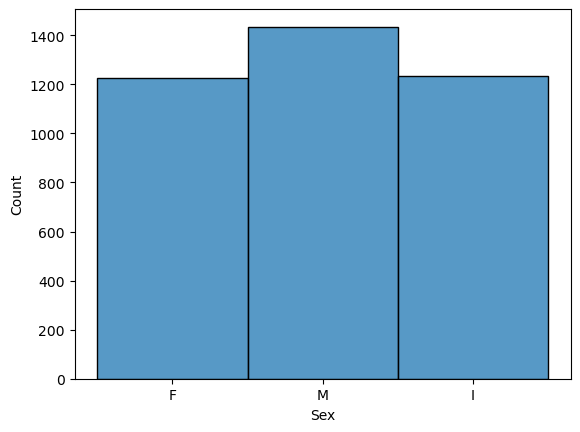

In [244]:
sns.histplot(dataset['Sex'])

Pretty balanced distribution of sexes in the dataset

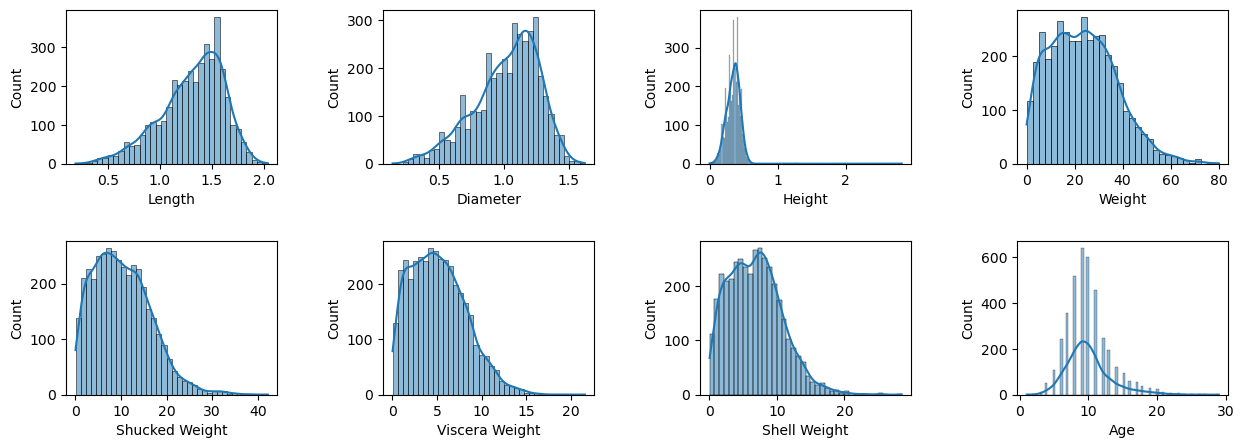

In [245]:
fig, axes = plt.subplots(2, 4, figsize=(15, 5))
plt.subplots_adjust(hspace=0.5, wspace=0.5)

testdataset = dataset.drop('Sex', axis=1)
for i in testdataset.columns:
    if testdataset.columns.get_loc(i) < 4:
        sns.histplot(dataset[i], kde=True, ax=axes[0, testdataset.columns.get_loc(i)])
    else:
        sns.histplot(dataset[i], kde=True, ax=axes[1, (testdataset.columns.get_loc(i) % 4)])  

In [246]:
numberic_dataset = dataset.drop('Sex', axis=1)
for i in numberic_dataset.columns:
    skewness = round(dataset[i].skew(), 3)
    kurtosis = round(dataset[i].kurt(), 3)
    print(f"'{i}' has a skewness of {skewness} and kurtosis of {kurtosis}")
    # add more code to plot these values to visualize comparisons  easier

'Length' has a skewness of -0.651 and kurtosis of 0.077
'Diameter' has a skewness of -0.617 and kurtosis of -0.041
'Height' has a skewness of 3.313 and kurtosis of 80.222
'Weight' has a skewness of 0.519 and kurtosis of -0.023
'Shucked Weight' has a skewness of 0.703 and kurtosis of 0.576
'Viscera Weight' has a skewness of 0.578 and kurtosis of 0.088
'Shell Weight' has a skewness of 0.608 and kurtosis of 0.517
'Age' has a skewness of 1.105 and kurtosis of 2.337


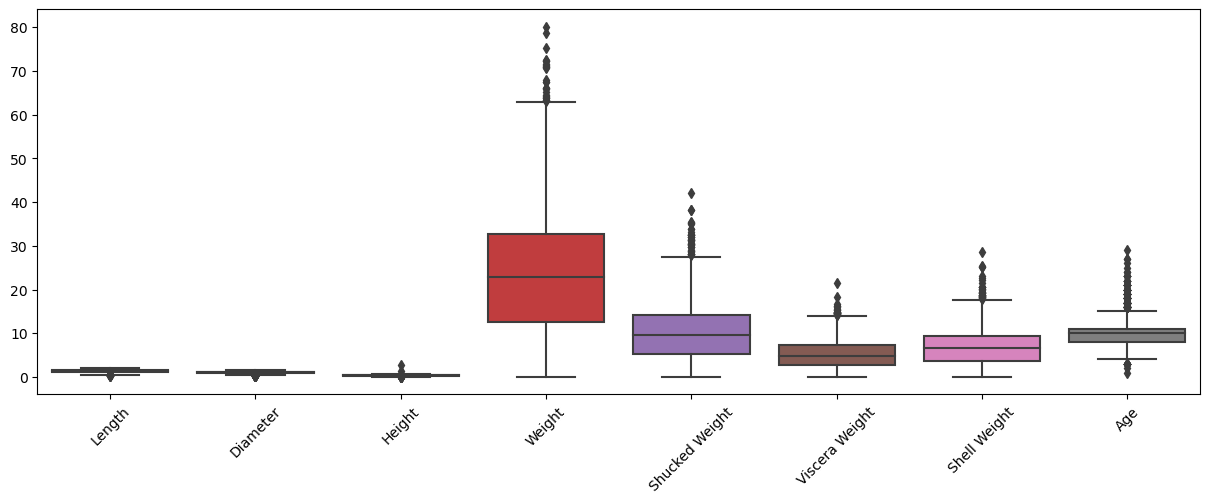

In [247]:
# box and whisker - visual representation of df.describe()
boxplotdata = dataset.drop('Sex', axis=1)
plt.figure(figsize=(15, 5))
sns.boxplot(data=boxplotdata)
plt.xticks(rotation=45)
plt.show()

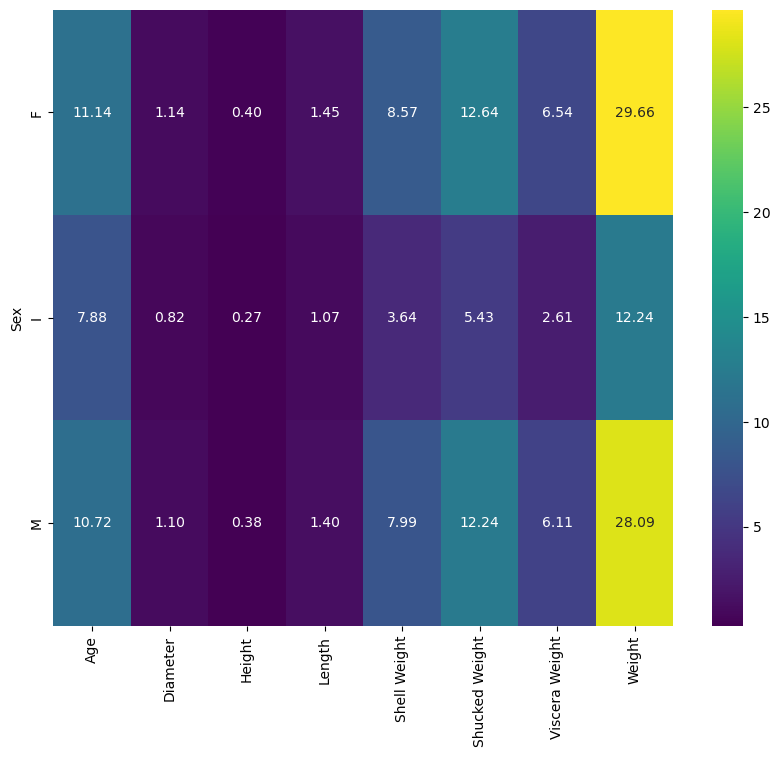

In [248]:
# plot the relationships between averages of numberic features grouped by 'Sex' category
plt.figure(figsize=(10, 8))
sns.heatmap(dataset.pivot_table(index='Sex', aggfunc='mean'), annot=True, cmap='viridis', fmt='.2f')
plt.show()

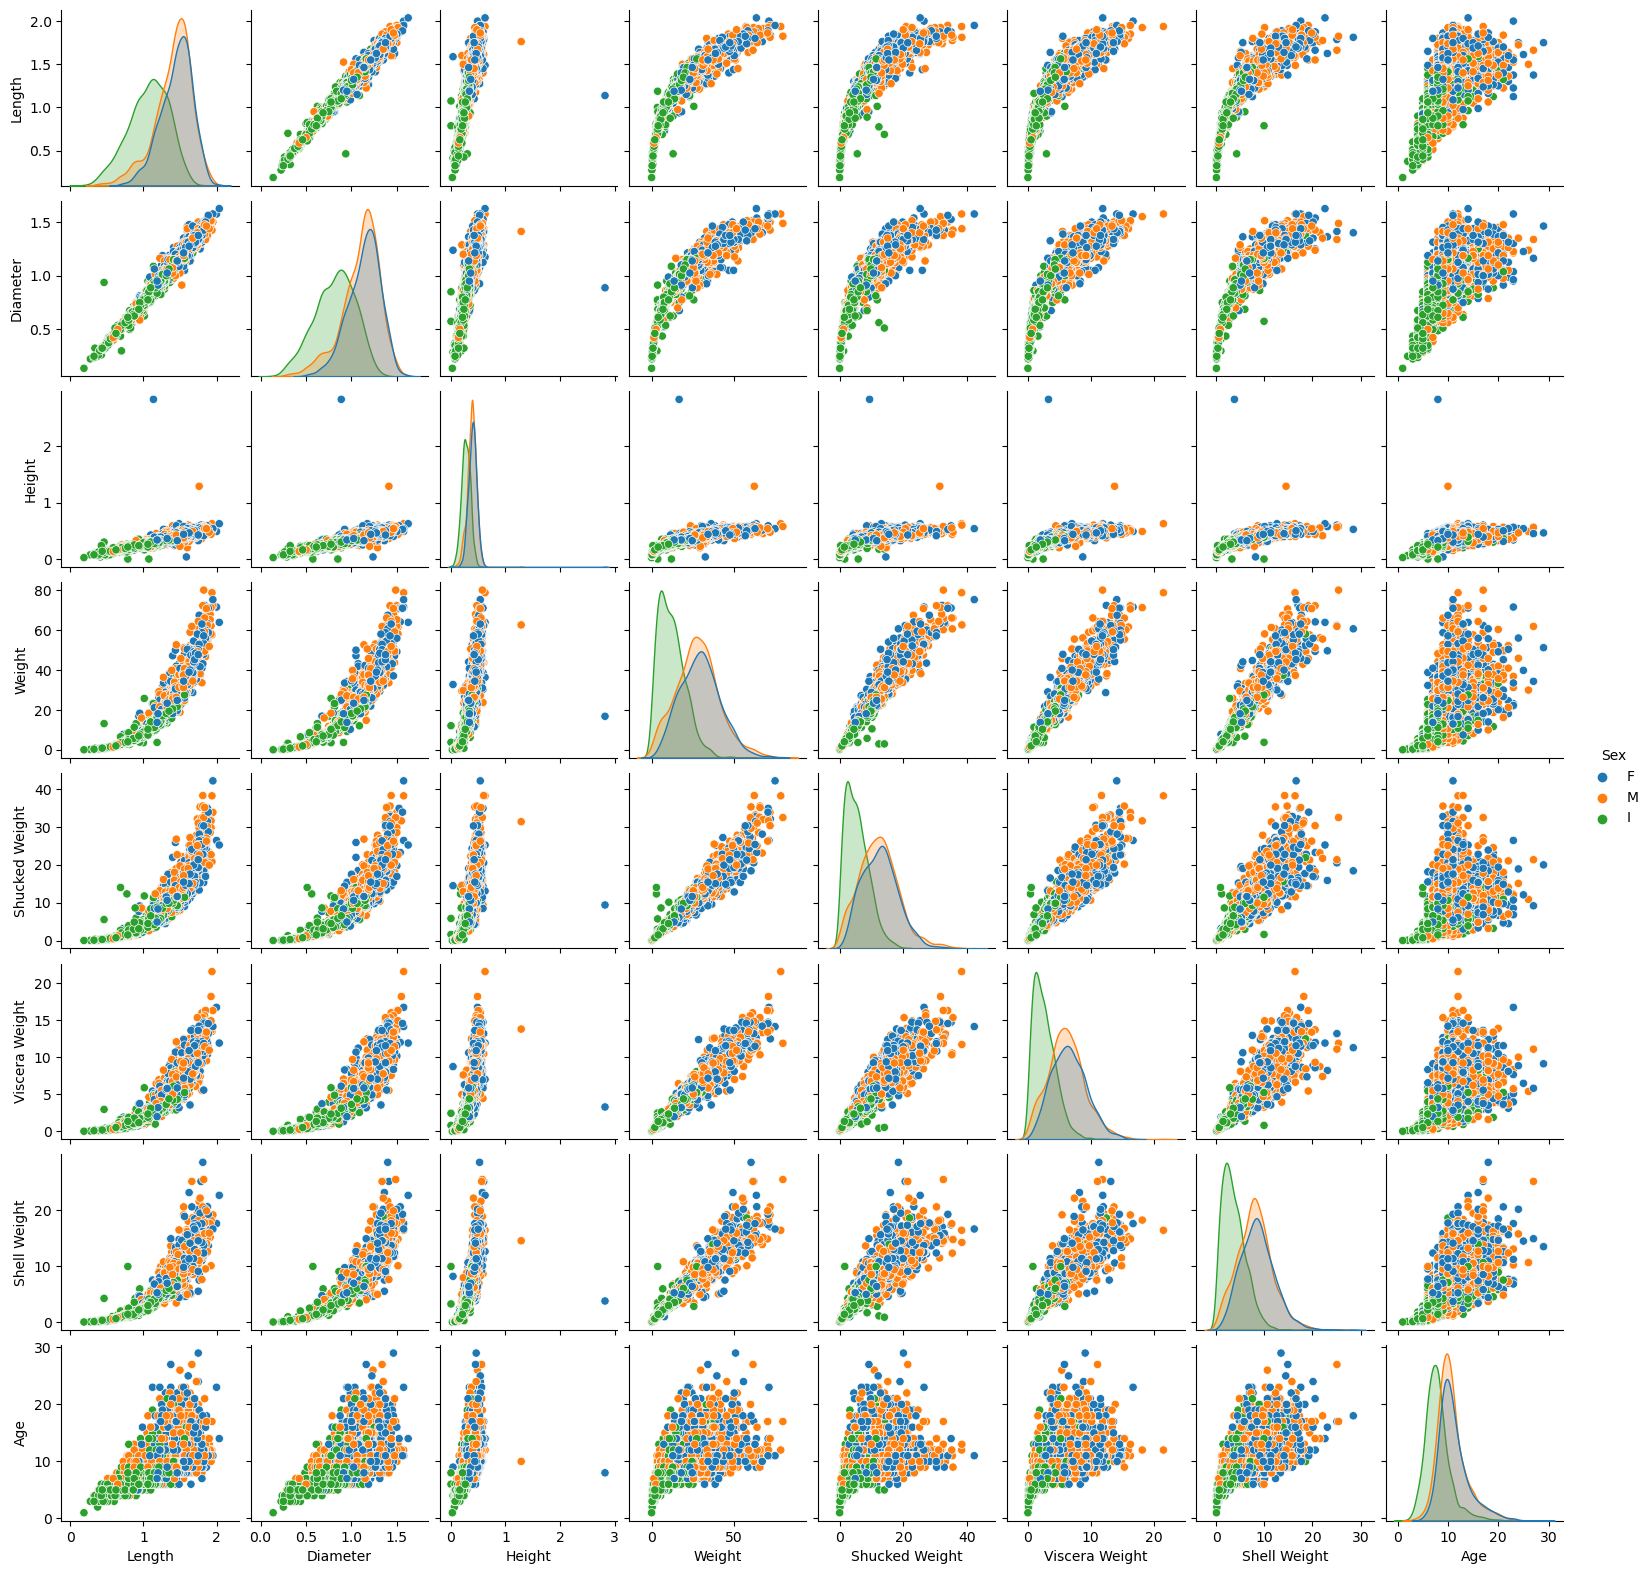

In [249]:
# Multivariate analysis - pariplot to visualize the interactions of the features, grouped by 'Sex' - only categorical variable in the dataset
sns.pairplot(dataset, hue='Sex', height=2)

In [250]:
# Multivariate analysis - Feature correlation strength quantified by Person's R coefficient
correlation_matrix = pd.DataFrame(dataset.corr())
for idx, row in correlation_matrix.iterrows():
    for col in correlation_matrix.columns:
        if correlation_matrix.loc[idx, col] > 0.5:
            correlation_matrix.loc[idx, col] = 'Strong' # categorizations of correlation strength based on Person's R coefficient 
        elif (0.3 < correlation_matrix.loc[idx, col] <= 0.5):
                correlation_matrix.loc[idx, col] = 'Moderate'
        elif (correlation_matrix.loc[idx, col] <= 0.3):
                correlation_matrix.loc[idx, col] = 'Weak'
        else:
            correlation_matrix.loc[idx, col] = 'Undefined'

C:\Users\lannand\AppData\Local\Temp\ipykernel_45512\1638598027.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = pd.DataFrame(dataset.corr())


In [251]:
correlation_matrix

,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
Length,Strong,Strong,Strong,Strong,Strong,Strong,Strong,Strong
Diameter,Strong,Strong,Strong,Strong,Strong,Strong,Strong,Strong
Height,Strong,Strong,Strong,Strong,Strong,Strong,Strong,Strong
Weight,Strong,Strong,Strong,Strong,Strong,Strong,Strong,Strong
Shucked Weight,Strong,Strong,Strong,Strong,Strong,Strong,Strong,Moderate
Viscera Weight,Strong,Strong,Strong,Strong,Strong,Strong,Strong,Strong
Shell Weight,Strong,Strong,Strong,Strong,Strong,Strong,Strong,Strong
Age,Strong,Strong,Strong,Strong,Moderate,Strong,Strong,Strong


In [252]:
# Multivariate analysis - Feature correlation strength quantified by Person's R coefficient - broken down by categorical feature ('Sex')
grouped_dataset = dataset.groupby('Sex') # create 3 datasets, one for each sex, then look at correlations between features by sex
m_df = grouped_dataset.get_group('M')
f_df = grouped_dataset.get_group('F')
i_df = grouped_dataset.get_group('I')

# Amend the following code and build it all within one loop..... 
m_correlation_matrix = pd.DataFrame(m_df.corr())
for idx, row in m_correlation_matrix.iterrows():
    for col in m_correlation_matrix.columns:
        if m_correlation_matrix.loc[idx, col] > 0.5:
            m_correlation_matrix.loc[idx, col] = 'Strong' # categorizations of correlation strength based on Person's R coefficient 
        elif (0.3 < m_correlation_matrix.loc[idx, col] <= 0.5):
                m_correlation_matrix.loc[idx, col] = 'Moderate'
        elif (m_correlation_matrix.loc[idx, col] <= 0.3):
                m_correlation_matrix.loc[idx, col] = 'Weak'
        else:
            m_correlation_matrix.loc[idx, col] = 'Undefined'

f_correlation_matrix = pd.DataFrame(f_df.corr())
for idx, row in f_correlation_matrix.iterrows():
    for col in f_correlation_matrix.columns:
        if f_correlation_matrix.loc[idx, col] > 0.5:
            f_correlation_matrix.loc[idx, col] = 'Strong'
        elif (0.3 < f_correlation_matrix.loc[idx, col] <= 0.5):
                f_correlation_matrix.loc[idx, col] = 'Moderate'
        elif (f_correlation_matrix.loc[idx, col] <= 0.3):
                f_correlation_matrix.loc[idx, col] = 'Weak'
        else:
            f_correlation_matrix.loc[idx, col] = 'Undefined'

i_correlation_matrix = pd.DataFrame(i_df.corr())
for idx, row in i_correlation_matrix.iterrows():
    for col in i_correlation_matrix.columns:
        if i_correlation_matrix.loc[idx, col] > 0.5:
            i_correlation_matrix.loc[idx, col] = 'Strong'
        elif (0.3 < i_correlation_matrix.loc[idx, col] <= 0.5):
                i_correlation_matrix.loc[idx, col] = 'Moderate'
        elif (i_correlation_matrix.loc[idx, col] <= 0.3):
                i_correlation_matrix.loc[idx, col] = 'Weak'
        else:
            i_correlation_matrix.loc[idx, col] = 'Undefined'

# Use these to assess any differences between correlation strength and category feature (Sex)

C:\Users\lannand\AppData\Local\Temp\ipykernel_45512\3028554641.py:8: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  m_correlation_matrix = pd.DataFrame(m_df.corr())
C:\Users\lannand\AppData\Local\Temp\ipykernel_45512\3028554641.py:20: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  f_correlation_matrix = pd.DataFrame(f_df.corr())
C:\Users\lannand\AppData\Local\Temp\ipykernel_45512\3028554641.py:32: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  i_correlation_matrix = pd.DataFrame(

In [253]:
numeric_features = numberic_dataset.columns.to_list() # numberic feature names
differences = []
for i in numeric_features:
    for j in numeric_features:
        i_entry = i_correlation_matrix.loc[i, j]
        f_entry = f_correlation_matrix.loc[i, j]
        m_entry = m_correlation_matrix.loc[i, j]
        if i_entry != f_entry or f_entry != m_entry:
            differences.append({
                'Feature Pair': (i, j),
                'i_correlation_matrix': i_entry,
                'f_correlation_matrix': f_entry,
                'm_correlation_matrix': m_entry
            })

In [254]:
differencesdf = pd.DataFrame(differences)

In [255]:
differencesdf

,Feature Pair,i_correlation_matrix,f_correlation_matrix,m_correlation_matrix
0,"(Length, Age)",Strong,Weak,Moderate
1,"(Diameter, Age)",Strong,Weak,Moderate
2,"(Height, Age)",Strong,Weak,Moderate
3,"(Weight, Age)",Strong,Weak,Moderate
4,"(Shucked Weight, Age)",Strong,Weak,Weak
5,"(Viscera Weight, Age)",Strong,Weak,Moderate
6,"(Shell Weight, Age)",Strong,Moderate,Strong
7,"(Age, Length)",Strong,Weak,Moderate
8,"(Age, Diameter)",Strong,Weak,Moderate
9,"(Age, Height)",Strong,Weak,Moderate


In [256]:
# Check for missing data points and replace any instances with the mean of the field
for i in dataset.columns:
    missing_values = dataset[i].isnull().sum()
    print(f"Missing values in {i}: {missing_values}")

# could use dataset.dropna(inplace = True) here?? instead of this loop

Missing values in Sex: 0
Missing values in Length: 0
Missing values in Diameter: 0
Missing values in Height: 0
Missing values in Weight: 1
Missing values in Shucked Weight: 0
Missing values in Viscera Weight: 1
Missing values in Shell Weight: 1
Missing values in Age: 0


In [257]:
# Replace missing values with the mean of respective fields
for i in dataset.columns:
    if dataset[i].isnull().sum() > 0:
        index = dataset[dataset[i].isnull()].index
        dataset.loc[index, i] = dataset[i].mean()

In [258]:
# Remove outliers in dataset based on Z-score > 2
for i in dataset.columns.drop('Sex'):
    z = np.abs(stats.zscore(dataset[i])) # calculates the zsocre for current column 
    rows_to_drop = dataset.index[z > 2]
    dataset = dataset.drop(rows_to_drop)

In [259]:
# Features Engineering
# with the current characteristics, what other characteristics can be calculated?
# i.e., density, volume, etc
dataset['volume'] = dataset['Length'] * dataset['Diameter'] * dataset['Height'] # calculate the volume of the crab, with volume, density can be calculated (mass / volume)
dataset['density'] = dataset['Weight'] / dataset['volume'] # density of the crab


# density and weight features are with shell, but can also calculate without shell on - could potentially account for things like muscle atrophy as crab passes certain age
dataset['noshell_weight'] = dataset['Weight'] - dataset['Shell Weight']
dataset['noshell_density'] = dataset['noshell_weight'] / dataset['volume'] # this could be flawed because the measurements for volume likely involve shell measurements

# place new features at start
dataset.insert(0, 'density', dataset.pop('density'))
dataset.insert(0, 'volume', dataset.pop('volume'))
dataset.insert(0, 'noshell_weight', dataset.pop('noshell_weight'))
dataset.insert(0, 'noshell_density', dataset.pop('noshell_density'))

In [260]:
# OneHotEncoder on categorical feature (Sex)
# ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [4])], remainder = 'passthrough')
# dataset = pd.DataFrame(ct.fit_transform(dataset))

# why doesnt this work? why am i forced to use pd.get_dummies if i want feature names to remain?

In [261]:
# One hot encode 'Sex' field
sex = pd.get_dummies(dataset['Sex'])
dataset = pd.concat([sex, dataset], axis=1)
dataset.drop('Sex', axis = 1, inplace = True)

In [265]:
dataset

,F,I,M,noshell_density,noshell_weight,volume,density,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
0,1,0,0,25.674683,17.888534,0.696738,35.358636,1.4375,1.1750,0.4125,24.635715,12.332033,5.584852,6.747181,9.0
1,0,0,1,31.336035,3.841357,0.122586,44.055459,0.8875,0.6500,0.2125,5.400580,2.296310,1.374951,1.559222,6.0
2,0,1,0,25.808733,5.187959,0.201016,39.559287,1.0375,0.7750,0.2500,7.952035,3.231843,1.601747,2.764076,6.0
3,1,0,0,31.589686,8.235530,0.260703,51.707041,1.1750,0.8875,0.2500,13.480187,4.748541,2.282135,5.244657,10.0
4,0,1,0,41.635932,5.202133,0.124943,55.249861,0.8875,0.6625,0.2125,6.903103,3.458639,1.488349,1.700970,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3886,1,0,0,22.412015,8.533199,0.380742,36.186841,1.1875,0.9500,0.3375,13.777857,4.918638,1.984465,5.244657,7.0
3887,1,0,0,33.427190,16.456885,0.492320,47.535134,1.3250,1.0250,0.3625,23.402512,10.631063,5.783298,6.945627,9.0
3889,1,0,0,34.108456,18.441350,0.540668,45.906154,1.4625,1.1375,0.3250,24.819987,11.651645,5.854172,6.378637,8.0
3890,1,0,0,30.013917,24.678240,0.822227,41.909151,1.5500,1.2125,0.4375,34.458817,15.450477,7.172423,9.780577,10.0


In [280]:
# create dependent and independent variable arrays, and split into training and testings sets (20% testing size)
X = dataset.iloc[:, : -1].values
y = dataset.iloc[:, -1].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [287]:
# Apply feature scaling to non-dummy variables 
sc = StandardScaler()
X_train[:, 3:] = sc.fit_transform(X_train[:, 3:])
X_test[:, 3:] = sc.fit_transform(X_test[:, 3:])

In [291]:
regressor = RandomForestRegressor(n_estimators=50) # Try the random forest regressor
regressor.fit(X_train, y_train)

RandomForestRegressor(n_estimators=50)

In [292]:
accuracies = cross_val_score(estimator = regressor, X = X_train, y = y_train, cv=10)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Std: {:.2f} %".format(accuracies.std()*100))

Accuracy: 41.63 %
Std: 5.67 %


In [300]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False],
    'criterion': ['squared_error', 'absolute_error'],
    'random_state': [42, 123, None]
}
grid_search = GridSearchCV(estimator = regressor,
                           param_grid = param_grid, 
                           scoring = 'accuracy',
                           cv = 10,
                           n_jobs = -1)
grid_search.fit(X_train, y_train)
best_accuracy = grid_search.best_score_
best_params = grid_search.best_params_

print("Best Accuracy {:.2f} %".format(best_accuracy*100))
print("Best hyperparam values:", best_params)

KeyboardInterrupt: 